In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
import itertools
from fault_cnn import WindFaultDataset, WindFaultCNN, test_model, validate_model, train_model, prepare_datasets

In [10]:
param_grid = {
    'window_size': [5, 10, 15, 20],  # Test smaller window sizes
    'overlap_size': [0, 2, 5],        # Relative to window size
    'learning_rate': [0.001, 0.005],
    'batch_size': [32, 64],
    'num_epochs': [30, 50],          # Increased epochs for smaller windows
    'optimizer': ['Adam']
}

4-9 grid search attempt


Testing params: (5, 0, 0.001, 32, 30, 'Adam')
Epoch 1, Loss: 1.6095199926798347
Epoch 2, Loss: 1.6092492480812461
Epoch 3, Loss: 1.608549257032736
Epoch 4, Loss: 1.6011204034133422
Epoch 5, Loss: 1.5894285825662737
Epoch 6, Loss: 1.5853560212050637
Epoch 7, Loss: 1.577732281913924
Epoch 8, Loss: 1.5735015681737374
Epoch 9, Loss: 1.5586621239022223
Epoch 10, Loss: 1.556615632694361
Epoch 11, Loss: 1.5644404242652994
Epoch 12, Loss: 1.5479476854443723
Epoch 13, Loss: 1.5434975851397674
Epoch 14, Loss: 1.5405187417673059
Epoch 15, Loss: 1.5388427771508606
Epoch 16, Loss: 1.5348603536294885
Epoch 17, Loss: 1.5297373293789194
Epoch 18, Loss: 1.5295347228667968
Epoch 19, Loss: 1.5314398971013454
Epoch 20, Loss: 1.5257574137641874
Epoch 21, Loss: 1.5249110590422519
Epoch 22, Loss: 1.5284874442709933
Epoch 23, Loss: 1.5185065982643693
Epoch 24, Loss: 1.5221837337360633
Epoch 25, Loss: 1.5231139871577855
Epoch 26, Loss: 1.5259194375819687
Epoch 27, Loss: 1.5224087701614246
Epoch 28, Loss: 1.52

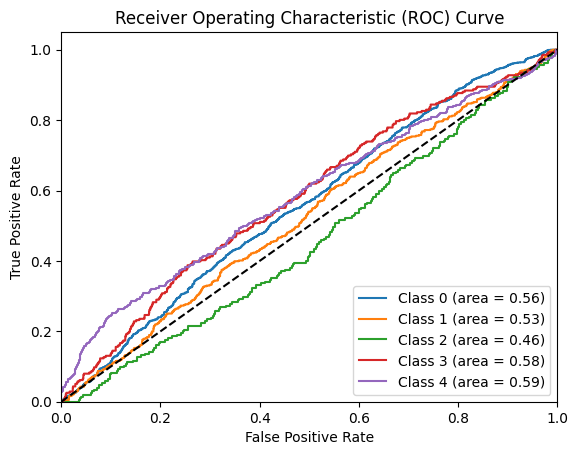

Final Test Accuracy: 0.5011
              precision    recall  f1-score   support

           0     0.5132    0.9573    0.6682      1404
           1     0.8000    0.0081    0.0161       491
           2     0.0000    0.0000    0.0000       205
           3     0.1923    0.0181    0.0331       276
           4     0.4097    0.1335    0.2014       442

    accuracy                         0.5011      2818
   macro avg     0.3830    0.2234    0.1838      2818
weighted avg     0.4782    0.5011    0.3705      2818



In [ ]:
best_accuracy = 0
best_params = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter search loop
for params in itertools.product(*param_grid.values()):
    window_size, overlap_size, lr, batch_size, num_epochs, optimizer_name = params
    print(f"\nTesting params: {params}")
    
    try:
        # Prepare datasets
        train_dataset, val_dataset, test_dataset = prepare_datasets(
            csv_path='combined_balanced_dataset.csv',
            label_column='Fault_Type',
            window_size=window_size,
            overlap_size=overlap_size,
            test_size=0.2,
            val_size=0.25
        )
        
        # Calculate class weights
        class_counts = np.bincount(train_dataset.labels)
        total_samples = class_counts.sum()
        num_classes = len(class_counts)
        class_weights = torch.tensor(total_samples / (num_classes * class_counts), dtype=torch.float32)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        num_features = train_dataset.data.shape[2]
        model2 = WindFaultCNN(
            input_channels=num_features,
            num_classes=num_classes,
            window_size=window_size
        ).to(device)

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model2.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model2.parameters(), lr=lr)

        # Train and validate
        #train_model(model, train_loader, num_epochs, optimizer, class_weights, device)
        val_accuracy = validate_model(model2, val_loader, class_weights, device)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params
            torch.save(model2.state_dict(), 'best_model.pth')
            print(f"New best accuracy: {best_accuracy:.4f}")

    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        continue

# Evaluate best model on test set
print(f"\nBest parameters: {best_params}")
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path='combined_balanced_dataset.csv',
    label_column='Fault_Type',
    window_size=best_params[0],
    overlap_size=best_params[1]
)

test_loader = DataLoader(test_dataset, batch_size=best_params[3], shuffle=False)
best_model = WindFaultCNN(
    input_channels=train_dataset.data.shape[2],
    num_classes=len(np.unique(train_dataset.labels)),
    window_size=best_params[0]
).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

class_counts = np.bincount(train_dataset.labels)
class_weights = torch.tensor(class_counts.sum() / (len(class_counts) * class_counts), dtype=torch.float32)
# Note that evaluate model is deprecated, now use test_model
final_accuracy, report, conf_matrix, roc_auc = evaluate_model(
    best_model, test_loader, 
    nn.CrossEntropyLoss(weight=class_weights.to(device)),
    len(class_counts)
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

Try that best run with 100 epochs. Or in a loop to keep going if loss does not go down anymore. 

WindFaultCNN(
  (conv1): Conv1d(19, 16, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=7)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch 1/100 | Train Loss: 1.6098 | Val Loss: 1.6090
Epoch 2/100 | Train Loss: 1.6094 | Val Loss: 1.6090
Epoch 3/100 | Train Loss: 1.6093 | Val Loss: 1.6090
Epoch 4/100 | Train Loss: 1.6092 | Val Loss: 1.6090
Epoch 5/100 | Train Loss: 1.6093 | Val Loss: 1.6090
Epoch 6/100 | Train Loss: 1.6095 | Val Loss: 1.6091
Epoch 7/100 | Train Loss: 1.6093 | Val Loss: 1.6090
Epoch 8/100 | Train Loss: 1.6092 | Val Loss: 1.6091
Epoch 9/100 | Train Loss: 1.6092 | Val Loss: 1.6079
Epoch 10/100 | Train Loss: 1.6077 | Val Loss: 1.6042
Epoch 11/100 | Train Loss: 1.6059 | Val Loss: 1.6040
Epoch 12/100 | Train Loss: 1.6043 | Val Loss: 1.6017
Epoch 1

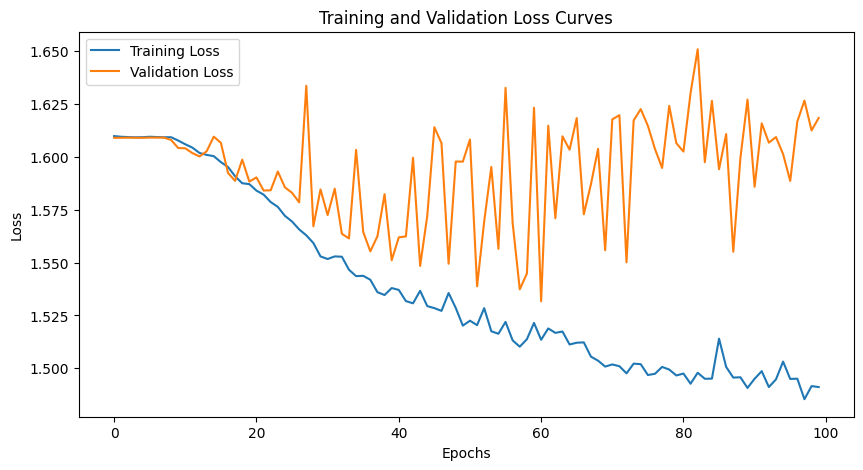

Training complete.
Test Loss: 1.5801
Test Accuracy: 0.2300

Classification Report:
               precision    recall  f1-score   support

           0     0.5912    0.1823    0.2787      1404
           1     0.2564    0.0204    0.0377       491
           2     0.0514    0.1756    0.0796       205
           3     0.1389    0.5471    0.2216       276
           4     0.3488    0.4412    0.3896       442

    accuracy                         0.2300      2818
   macro avg     0.2774    0.2733    0.2014      2818
weighted avg     0.4113    0.2300    0.2340      2818


Confusion Matrix:
 [[256  25 415 526 182]
 [133  10 154 144  50]
 [ 12   1  36 100  56]
 [ 18   1  30 151  76]
 [ 14   2  65 166 195]]


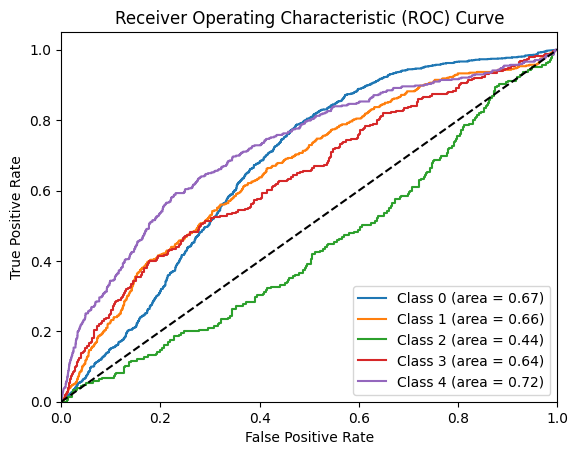

Final Test Accuracy: 0.2300
              precision    recall  f1-score   support

           0     0.5912    0.1823    0.2787      1404
           1     0.2564    0.0204    0.0377       491
           2     0.0514    0.1756    0.0796       205
           3     0.1389    0.5471    0.2216       276
           4     0.3488    0.4412    0.3896       442

    accuracy                         0.2300      2818
   macro avg     0.2774    0.2733    0.2014      2818
weighted avg     0.4113    0.2300    0.2340      2818



In [ ]:
param_grid = {
    'window_size': [50, 100, 150, 200],  # Test smaller window sizes
    'overlap_size': [10, 20],        # Relative to window size
    'learning_rate': [0.001, 0.005],
    'batch_size': [32],
    'num_epochs': [30, 50],          # Increased epochs for smaller windows
    'optimizer': ['Adam']
}

# Prepare datasets
csv_path = 'CombinedDataSensitive.csv'
label_column = 'Label'
window_size = 60
overlap_size = 5
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
production_model_v0 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size)
print(production_model_v0)
# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(production_model_v0.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 100
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = production_model_v0,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    production_model_v0, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

Trying an updated version of the CNN with more convolutional layers and a dropout layer. 

In [ ]:
# Prepare datasets
csv_path = 'combined_balanced_dataset.csv'
label_column = 'Fault_Type'
window_size = 15
overlap_size = 2
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
model4layers1 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size, dropout_rate=0.5)

# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(model4layers1.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 200
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = model4layers1,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    model4layers1, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

TypeError: WindFaultCNN.__init__() got an unexpected keyword argument 'dropout_rate'

4-13-25 Grid search attempt with New accurately labeled data. 

WindFaultCNN(
  (conv1): Conv1d(34, 16, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=25)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Class Counts [2988    3    8    5   26]
3030
Epoch 1/100 | Train Loss: 1.2787 | Val Loss: 1.0618
Epoch 2/100 | Train Loss: 1.2161 | Val Loss: 1.0618
Epoch 3/100 | Train Loss: 1.2226 | Val Loss: 1.0618
Epoch 4/100 | Train Loss: 1.2208 | Val Loss: 1.0618
Epoch 5/100 | Train Loss: 1.1908 | Val Loss: 1.0618
Epoch 6/100 | Train Loss: 1.2295 | Val Loss: 1.0618
Epoch 7/100 | Train Loss: 1.1990 | Val Loss: 1.0618
Epoch 8/100 | Train Loss: 1.1991 | Val Loss: 1.0618
Epoch 9/100 | Train Loss: 1.1907 | Val Loss: 1.0618
Epoch 10/100 | Train Loss: 1.2006 | Val Loss: 1.0618
Epoch 11/100 | Train Loss: 1.2136 | Val Loss: 1.0618
Epoch 12/100 |

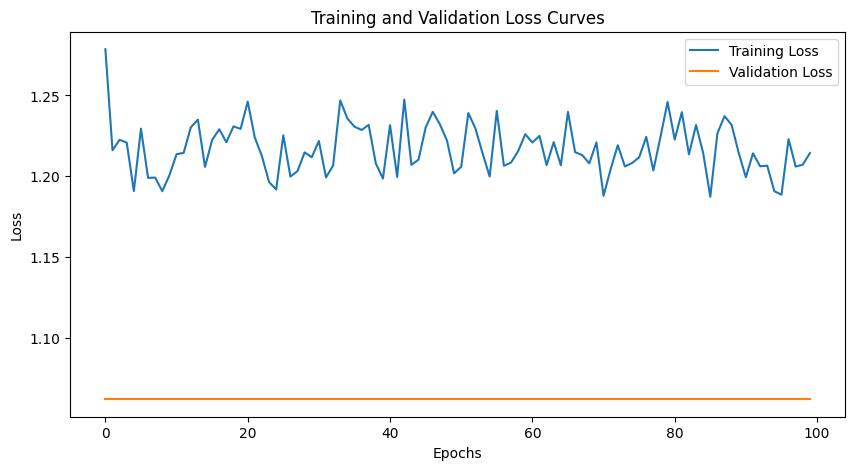

Training complete.
Test Loss: 1.3056
Test Accuracy: 0.9822

Classification Report:
               precision    recall  f1-score   support

           0     0.9822    1.0000    0.9910       992
           1     0.0000    0.0000    0.0000         3
           2     0.0000    0.0000    0.0000         3
           3     0.0000    0.0000    0.0000         5
           4     0.0000    0.0000    0.0000         7

    accuracy                         0.9822      1010
   macro avg     0.1964    0.2000    0.1982      1010
weighted avg     0.9647    0.9822    0.9733      1010


Confusion Matrix:
 [[992   0   0   0   0]
 [  3   0   0   0   0]
 [  3   0   0   0   0]
 [  5   0   0   0   0]
 [  7   0   0   0   0]]


c:\Users\aeg00011\temp_wind\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aeg00011\temp_wind\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aeg00011\temp_wind\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


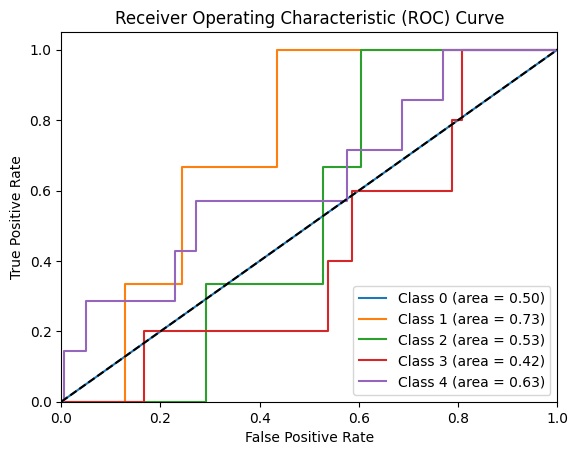

Final Test Accuracy: 0.9822
              precision    recall  f1-score   support

           0     0.9822    1.0000    0.9910       992
           1     0.0000    0.0000    0.0000         3
           2     0.0000    0.0000    0.0000         3
           3     0.0000    0.0000    0.0000         5
           4     0.0000    0.0000    0.0000         7

    accuracy                         0.9822      1010
   macro avg     0.1964    0.2000    0.1982      1010
weighted avg     0.9647    0.9822    0.9733      1010



In [8]:
param_grid = {
    'window_size': [50, 100, 150, 200],  # Test smaller window sizes
    'overlap_size': [10, 20],        # Relative to window size
    'learning_rate': [0.001, 0.005],
    'batch_size': [32],
    'num_epochs': [30, 50],          # Increased epochs for smaller windows
    'optimizer': ['Adam']
}

# Prepare datasets
csv_path = 'CombinedDataSensitive.csv'
label_column = 'Label'
window_size = 50
overlap_size = 10
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
production_model_v0 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size)
print(production_model_v0)
# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(production_model_v0.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
print("Class Counts", class_counts)
print(total_samples)
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 100
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = production_model_v0,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    production_model_v0, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

4-14-25 Manually added more faults to the dataset

WindFaultCNN(
  (conv1): Conv1d(34, 16, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=25)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Class Counts [3013    3   47   34   88]
3185
Epoch 1/100 | Train Loss: 1.5430 | Val Loss: 1.5017
Epoch 2/100 | Train Loss: 1.5145 | Val Loss: 1.5017
Epoch 3/100 | Train Loss: 1.4982 | Val Loss: 1.5017
Epoch 4/100 | Train Loss: 1.5466 | Val Loss: 1.4676
Epoch 5/100 | Train Loss: 1.3532 | Val Loss: 1.2778
Epoch 6/100 | Train Loss: 1.2930 | Val Loss: 1.2789
Epoch 7/100 | Train Loss: 1.2661 | Val Loss: 1.2797
Epoch 8/100 | Train Loss: 1.2089 | Val Loss: 1.1940
Epoch 9/100 | Train Loss: 1.1704 | Val Loss: 1.2050
Epoch 10/100 | Train Loss: 1.1490 | Val Loss: 1.1796
Epoch 11/100 | Train Loss: 1.1069 | Val Loss: 1.1902
Epoch 12/100 |

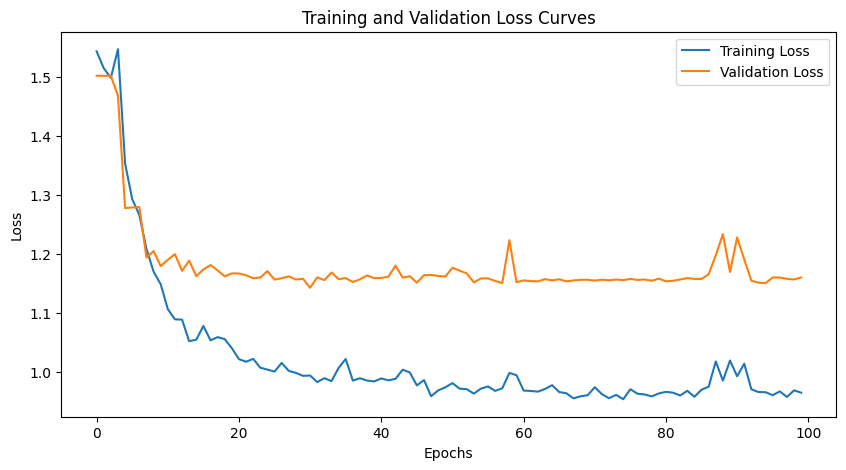

Training complete.
Test Loss: 1.1116
Test Accuracy: 0.9783

Classification Report:
               precision    recall  f1-score   support

           0     0.9960    0.9960    0.9960      1003
           1     0.0000    0.0000    0.0000         2
           2     0.1000    0.1111    0.1053         9
           3     0.4000    0.5000    0.4444         8
           4     0.9189    0.8718    0.8947        39

    accuracy                         0.9783      1061
   macro avg     0.4830    0.4958    0.4881      1061
weighted avg     0.9792    0.9783    0.9787      1061


Confusion Matrix:
 [[999   0   3   1   0]
 [  1   0   1   0   0]
 [  3   1   1   2   2]
 [  0   0   3   4   1]
 [  0   0   2   3  34]]


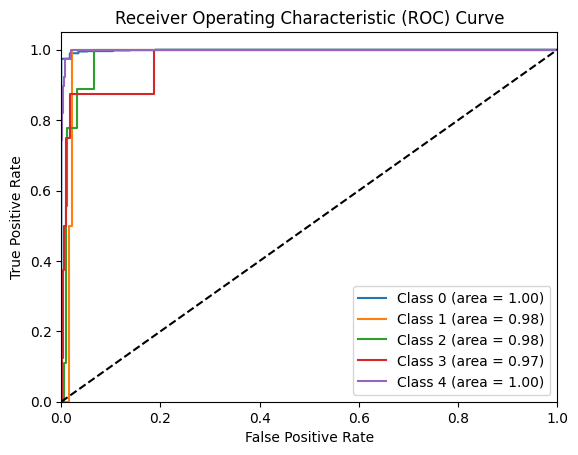

Final Test Accuracy: 0.9783
              precision    recall  f1-score   support

           0     0.9960    0.9960    0.9960      1003
           1     0.0000    0.0000    0.0000         2
           2     0.1000    0.1111    0.1053         9
           3     0.4000    0.5000    0.4444         8
           4     0.9189    0.8718    0.8947        39

    accuracy                         0.9783      1061
   macro avg     0.4830    0.4958    0.4881      1061
weighted avg     0.9792    0.9783    0.9787      1061



In [11]:
param_grid = {
    'window_size': [50, 100, 150, 200],  # Test smaller window sizes
    'overlap_size': [10, 20],        # Relative to window size
    'learning_rate': [0.001, 0.005],
    'batch_size': [32],
    'num_epochs': [30, 50],          # Increased epochs for smaller windows
    'optimizer': ['Adam']
}

# Prepare datasets
csv_path = 'CombinedDataSensitive.csv'
label_column = 'Label'
window_size = 50
overlap_size = 10
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
production_model_v0 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size)
print(production_model_v0)
# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(production_model_v0.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
print("Class Counts", class_counts)
print(total_samples)
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 100
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = production_model_v0,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    production_model_v0, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

WindFaultCNN(
  (conv1): Conv1d(34, 16, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=25)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Class Counts [2994   36   73   36  118]
3257
Epoch 1/100 | Train Loss: 1.6008 | Val Loss: 1.5099
Epoch 2/100 | Train Loss: 1.5005 | Val Loss: 1.2815
Epoch 3/100 | Train Loss: 1.3269 | Val Loss: 1.2138
Epoch 4/100 | Train Loss: 1.2691 | Val Loss: 1.1531
Epoch 5/100 | Train Loss: 1.2238 | Val Loss: 1.1326
Epoch 6/100 | Train Loss: 1.1826 | Val Loss: 1.1381
Epoch 7/100 | Train Loss: 1.1820 | Val Loss: 1.0946
Epoch 8/100 | Train Loss: 1.1359 | Val Loss: 1.1101
Epoch 9/100 | Train Loss: 1.1158 | Val Loss: 1.0987
Epoch 10/100 | Train Loss: 1.1438 | Val Loss: 1.0929
Epoch 11/100 | Train Loss: 1.0844 | Val Loss: 1.0791
Epoch 12/100 |

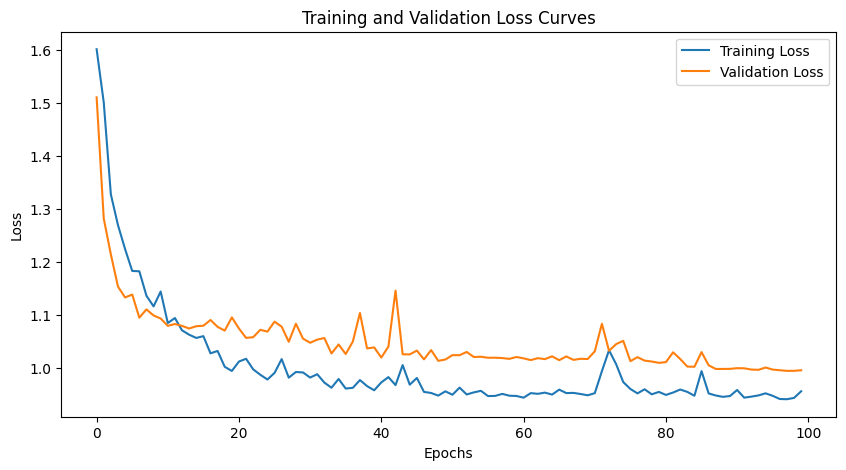

Training complete.
Test Loss: 1.0828
Test Accuracy: 0.9825

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995      1000
           1     0.7857    0.8462    0.8148        13
           2     0.7143    0.8333    0.7692        24
           3     0.5000    0.4615    0.4800        13
           4     0.9375    0.8571    0.8955        35

    accuracy                         0.9825      1085
   macro avg     0.7875    0.7994    0.7918      1085
weighted avg     0.9831    0.9825    0.9826      1085


Confusion Matrix:
 [[999   0   1   0   0]
 [  0  11   2   0   0]
 [  0   1  20   3   0]
 [  0   0   5   6   2]
 [  0   2   0   3  30]]


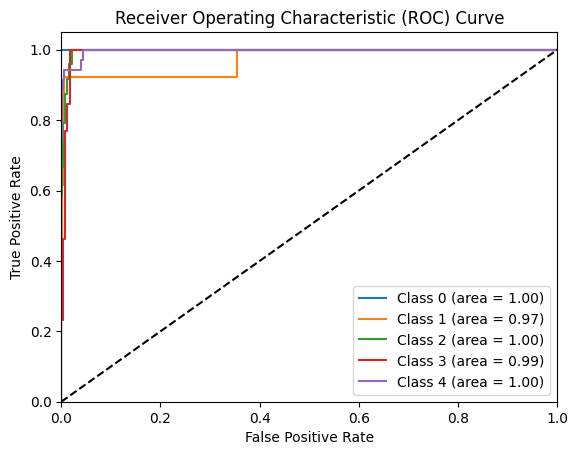

Final Test Accuracy: 0.9825
              precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995      1000
           1     0.7857    0.8462    0.8148        13
           2     0.7143    0.8333    0.7692        24
           3     0.5000    0.4615    0.4800        13
           4     0.9375    0.8571    0.8955        35

    accuracy                         0.9825      1085
   macro avg     0.7875    0.7994    0.7918      1085
weighted avg     0.9831    0.9825    0.9826      1085



In [12]:
param_grid = {
    'window_size': [50, 100, 150, 200],  # Test smaller window sizes
    'overlap_size': [10, 20],        # Relative to window size
    'learning_rate': [0.001, 0.005],
    'batch_size': [32],
    'num_epochs': [30, 50],          # Increased epochs for smaller windows
    'optimizer': ['Adam']
}

# Prepare datasets
csv_path = 'CombinedDataSensitive.csv'
label_column = 'Label'
window_size = 50
overlap_size = 10
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
production_model_v0 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size)
print(production_model_v0)
# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(production_model_v0.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
print("Class Counts", class_counts)
print(total_samples)
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 100
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = production_model_v0,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    production_model_v0, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

4-14
This model seems to be performing really well so I am going to save it for now. 


WindFaultCNN(
  (conv1): Conv1d(34, 16, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=25)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Class Counts [3011   94   70  262   96]
3533
Epoch 1/100 | Train Loss: 1.6057 | Val Loss: 1.5935
Epoch 2/100 | Train Loss: 1.4878 | Val Loss: 1.3444
Epoch 3/100 | Train Loss: 1.2839 | Val Loss: 1.2111
Epoch 4/100 | Train Loss: 1.1935 | Val Loss: 1.2061
Epoch 5/100 | Train Loss: 1.1697 | Val Loss: 1.1563
Epoch 6/100 | Train Loss: 1.1659 | Val Loss: 1.1653
Epoch 7/100 | Train Loss: 1.1397 | Val Loss: 1.1448
Epoch 8/100 | Train Loss: 1.1455 | Val Loss: 1.1485
Epoch 9/100 | Train Loss: 1.1420 | Val Loss: 1.1550
Epoch 10/100 | Train Loss: 1.1255 | Val Loss: 1.1408
Epoch 11/100 | Train Loss: 1.1203 | Val Loss: 1.1446
Epoch 12/100 |

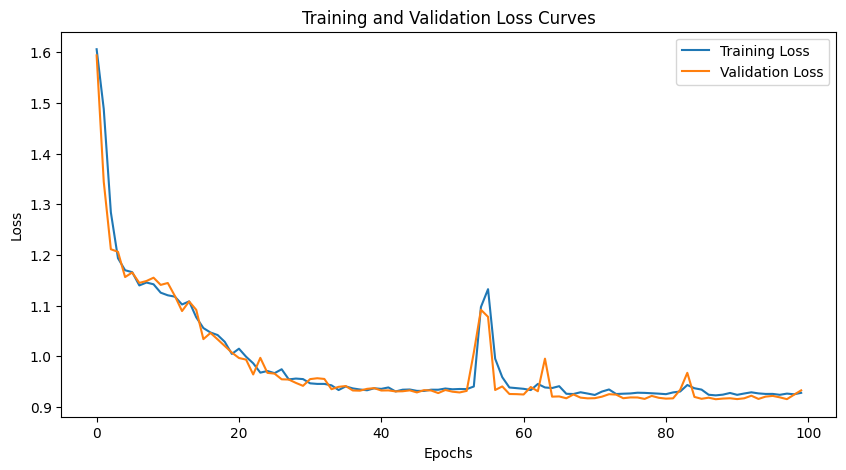

Training complete.
Test Loss: 0.9452
Test Accuracy: 0.9915

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9970    0.9985      1007
           1     0.9655    0.9032    0.9333        31
           2     0.6923    1.0000    0.8182        18
           3     0.9885    0.9773    0.9829        88
           4     1.0000    0.9394    0.9688        33

    accuracy                         0.9915      1177
   macro avg     0.9293    0.9634    0.9403      1177
weighted avg     0.9935    0.9915    0.9920      1177


Confusion Matrix:
 [[1004    1    1    1    0]
 [   0   28    3    0    0]
 [   0    0   18    0    0]
 [   0    0    2   86    0]
 [   0    0    2    0   31]]


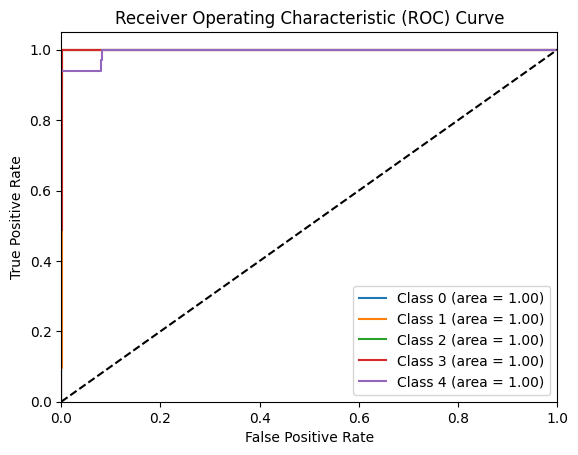

AttributeError: 'WindFaultCNN' object has no attribute 'save'

In [15]:

# Prepare datasets
csv_path = 'CombinedDataSensitive.csv'
label_column = 'Label'
window_size = 50
overlap_size = 10
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
production_model_v0 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size)
print(production_model_v0)
# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(production_model_v0.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
print("Class Counts", class_counts)
print(total_samples)
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 100
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = production_model_v0,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    production_model_v0, test_loader, criterion, num_classes
)
production_model_v0.save('sensitive_model_v1.pt')
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

In [ ]:
# Save the entire model
torch.save(production_model_v0, 'sensitive_model_v1_full.pth')
torch.save(production_model_v0.state_dict(), 'sensitive_model_v1_state_dict.pth')

In [ ]:
# Shape: (batch_size, sequence_length, channels)
example_input = torch.randn(32, 50, 34).to(device)
traced_script_module = torch.jit.trace(production_model_v0, example_input)
traced_script_module.save("sensitive_model_v1_traced.pt")
